  **Title** : " Steering Angle Prediction Based on Image using transfer learning " 

  **Author** : " Sri Ranga Sai Krishna Tummala "

  **Implementation_paper** : http://cs231n.stanford.edu/reports/2017/pdfs/626.pdf

# Importing required libraries

In [1]:
''' importing  required libraries '''

import os
import numpy as np
import pandas as pd
import cv2
import random
import ntpath
import glob
 
from IPython.display import HTML
from base64 import b64encode
from os import listdir
from  matplotlib import pyplot as plt
from matplotlib import image as img
from moviepy.editor import *
# Keras
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# Loading the data

In this project Udacity driving simulator has been used for generating the dataset. 

The driving simulator collects images  from three front-facing "cameras," along with the  various auxillary  information such as throttle, speed, and steering angle. We'll feed camera data into the model and predict steering angles in the [-1, 1] range.


In [2]:
# cloning the required files from the github repository 
!git clone 'https://github.com/sriranga03/641_project2.git'

fatal: destination path '641_project2' already exists and is not an empty directory.


In [3]:
# reading the data from csv 
data = pd.read_csv(os.path.join('641_project2', 'driving_log.csv'), names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019...,C:\Users\Win 10\Desktop\benign\IMG\left_2019_...,C:\Users\Win 10\Desktop\benign\IMG\right_2019...,0.0,0.0,0,0.000080


In [4]:
# dividing the path to seggregate images into center , right and left 

def normalise_path(path):
  address, image_path = ntpath.split(path)
  return image_path

data['center'] = data['center'].apply(normalise_path)
data['left'] = data['left'].apply(normalise_path)
data['right'] = data['right'].apply(normalise_path)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [5]:
# Loading the images and steering values into numpy arrays

def load_data_(df, data_directory = '641_project2/IMG/'):

  image_path = data.iloc[:,0]
  steering_angle = data.iloc[:,3]
  image_paths = []
  steerings = []
  for i in image_path:
    i = data_directory + i
    image_paths.append(i)
  image_paths = np.asarray(image_paths)
  for i in steering_angle:
    steerings.append(float(i))
  steerings = np.asarray(steerings)
  return image_paths, steerings

image_paths, steerings = load_data_(data)

In [6]:
# split the data into 70:30 for train and validation
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.3)


Training Samples: 1220
Valid Samples: 523



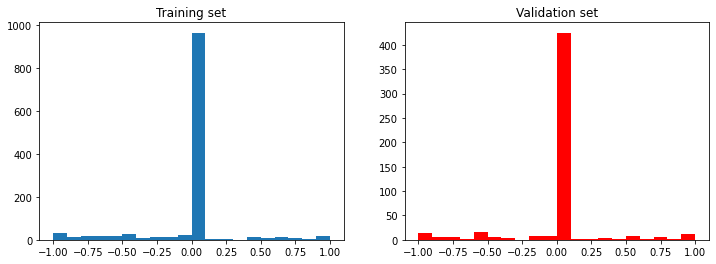

In [7]:
# Visualizing the distribution of data

print("Training Samples: {}\nValid Samples: {}\n".format(len(x_train), len(x_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Training set')
axes[0].hist(y_train, bins=20)
axes[1].set_title('Validation set')
axes[1].hist(y_valid, bins=20, color = 'red')
text = fig.text(0.5, 0.96, "$y=sin(x)$")
text.remove()


In [8]:
def img_preprocess(image):
  """Take in path of image, returns preprocessed image

     arguments:
        image: path of the image

  """
  image = img.imread(image)
  #crop and resize  
  image = image[60:135, :, :]
  image = cv2.resize(image, (100, 100))
  # Convert RGB 2 YUV and applying Gaussian Blur
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image, (3, 3), 0)
  # scale the image values
  image = image / 255
  return image

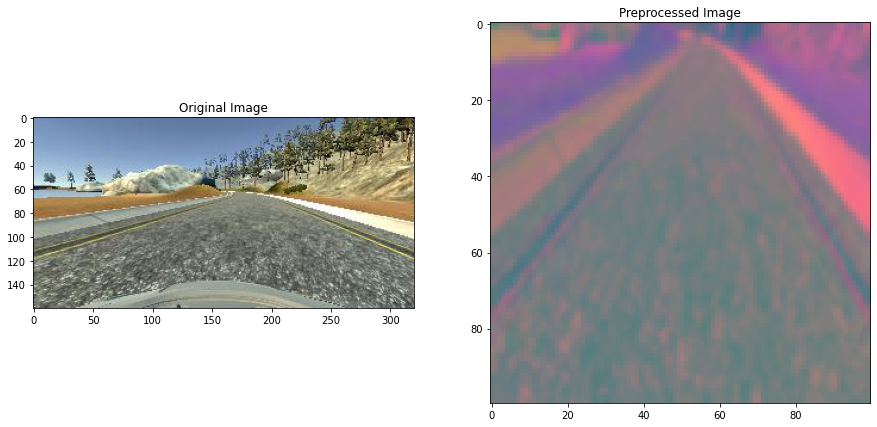

In [9]:
# Take a random inage
import random
rand_idx = int(random.random() * len(image_paths))
image = image_paths[rand_idx]
original_image = img.imread(image)
preprocessed_image = img_preprocess(image)

#Comparing the original and PreProcessed Images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].set_title('Original Image')
axes[0].imshow(original_image)
axes[1].set_title('Preprocessed Image')
axes[1].imshow(preprocessed_image)
text = fig.text(0.5, 0.96, "$y=sin(x)$")
text.remove()


In [10]:
# having the n
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

# Creating the  model and training the model


The learnings of Resnet50 pretrained on Imagenet Dataset are transferred to our newly built end to end model to predict the steering angle based on the Image from the camera.


    Input : Image from camera with the front view
    Output: predicted Steering angle
    

In [11]:
# Initializing the Resnet pretrained on Imagenet Dataset
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

#The weights of the first 15 ResNet blocks were blocked from updating
for layer in resnet.layers[:15]:
    layer.trainable = False

In [12]:
# building the end to end model
def end_to_end():
  model = Sequential()
  model.add(resnet)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

model = end_to_end()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

In [13]:
# trining the model
history = model.fit(x_train, y_train, epochs = 100, validation_data = (x_valid, y_valid), batch_size = 128, verbose=1)

Epoch 1/100
10/10 [==============================] - 17s 686ms/step - loss: 26.8268 - accuracy: 0.3525 - val_loss: 6.9856 - val_accuracy: 0.0172
Epoch 2/100
10/10 [==============================] - 3s 340ms/step - loss: 8.1832 - accuracy: 0.3705 - val_loss: 44699.4219 - val_accuracy: 0.8088
Epoch 3/100
10/10 [==============================] - 3s 342ms/step - loss: 12.5616 - accuracy: 0.3697 - val_loss: 1932.1276 - val_accuracy: 0.8088
Epoch 4/100
10/10 [==============================] - 4s 369ms/step - loss: 4.9799 - accuracy: 0.3467 - val_loss: 864.9026 - val_accuracy: 0.8088
Epoch 5/100
10/10 [==============================] - 3s 346ms/step - loss: 4.8830 - accuracy: 0.3713 - val_loss: 1319.9895 - val_accuracy: 0.8088
Epoch 6/100
10/10 [==============================] - 4s 378ms/step - loss: 4.0451 - accuracy: 0.3402 - val_loss: 662.2069 - val_accuracy: 0.8088
Epoch 7/100
10/10 [==============================] - 3s 347ms/step - loss: 3.4710 - accuracy: 0.3836 - val_loss: 153.2569 - v

Text(0.5, 0, 'Epoch')

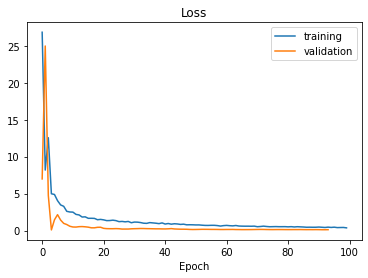

In [24]:
# plotting the train and validation loss 

plt.plot(history.history['loss'])
val_loss = []
for x in history.history['val_loss']:
  if x < 25:
    val_loss.append(x)
plt.plot(val_loss)
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# Testing the model

The created model is tested on real data set obtained and published by [Sully chen](https://github.com/SullyChen/Autopilot-TensorFlow).

The images and predicted angles are shown side by side as video.

In [15]:
'''   Testing the model on data set obtained from SullyChen Auto Pilot dataset    '''


smoothed_angle = 0
folder_dir = "/content/641_project2/data/"
image = []
for images in os.listdir(folder_dir):
	if (images.endswith(".jpg")):
		image.append(images)
 
# rotating the steering wheel image based on the predictions  
for i in image:
  predicting_image = img_preprocess(os.path.join('/content/641_project2/data/', i))
  predicting_image = predicting_image.reshape(-1,100,100,3)
  degrees = model.predict(predicting_image)* 180.0 
  imag = cv2.imread('/content/641_project2/steering_wheel_image.jpeg',0)
  rows,cols = imag.shape
  smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (abs(degrees) - smoothed_angle) / abs(degrees - smoothed_angle)
  M = cv2.getRotationMatrix2D((cols/2,rows/2),smoothed_angle,1)
  dst = cv2.warpAffine(imag,M,(cols,rows))
  cv2.imwrite('/content/test/steering_wheel0'+i, dst)  


In [16]:
'''  Creating the video from sequence of images from the predictions   '''

print(" Creating the video from sequence of images from the predictions")
!mkdir test
img_array = []
for filename in glob.glob("/content/test/*.jpg"):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('simul2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print(" successfully created video ")

 Creating the video from sequence of images from the predictions
mkdir: cannot create directory ‘test’: File exists
 successfully created video 


In [17]:
'''  Creating the video from sequence of images from the test dataset   '''

print("Making Video from test dataset")
img_array = []
for filename in glob.glob("/content/641_project2/data1/*.jpg"):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('simul.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print(" successfully created video")


Making Video from test dataset
 successfully created video


In [18]:
''' Displaying the images from car and predicted steering angle  side by side '''

# loading videos
clip1 = VideoFileClip("simul.mp4").subclip(0, 3)

clip2 = VideoFileClip("simul2.mp4").subclip(0, 3)

clips = [[clip1, clip2]]

# stacking clips
final = clips_array(clips)

# showing final clip
final.ipython_display(width = 640 )


 98%|█████████▊| 45/46 [00:00<00:00, 138.20it/s]
